# Regression, Classification and Partial-Dependence Plots

by Héctor Ramírez

<hr>

In this notebook, we study a simple dataset and construct both linear and logistic regression predictive models. We explain their performance using several metrics and, in particular, <a href='https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#id1'> partial-dependence plots</a>.

<hr>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import mean_squared_error as mse, r2_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
warnings.filterwarnings('ignore')

<hr>
We start by loading the data and explore its info and statistics. We see it comes with four features (two numerical columns, one of string type and one of boolean type). No null entries exist.
<hr>

In [3]:
data = pd.read_csv('salary.csv')
print(data.head())
print('\n')
print(data.info())
print('\n')
print(data.describe())

   Salary  Experience Education  Management
0   13876           1  Bachelor        True
1   11608           1       PhD       False
2   18701           1       PhD        True
3   11283           1    Master       False
4   11767           1       PhD       False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
Salary        46 non-null int64
Experience    46 non-null int64
Education     46 non-null object
Management    46 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 1.2+ KB
None


             Salary  Experience
count     46.000000   46.000000
mean   17270.195652    7.500000
std     4716.631513    5.171503
min    10535.000000    1.000000
25%    13320.750000    3.000000
50%    16436.000000    6.000000
75%    20719.750000   11.000000
max    27837.000000   20.000000


<hr>

### Goal
We are first interested in how the <i>Salary</i> variable is affected by the rest and, later, how the <i>Management</i> category is affected by the rest.

## Exploratory Data Analysis

We then perform an EDA of the variables in the dataset. First, we explore the relation between <i>Salary</i> and <i>Education</i> and then the relation between <i>Salary</i> and <i>Experience<i/>.
<hr>

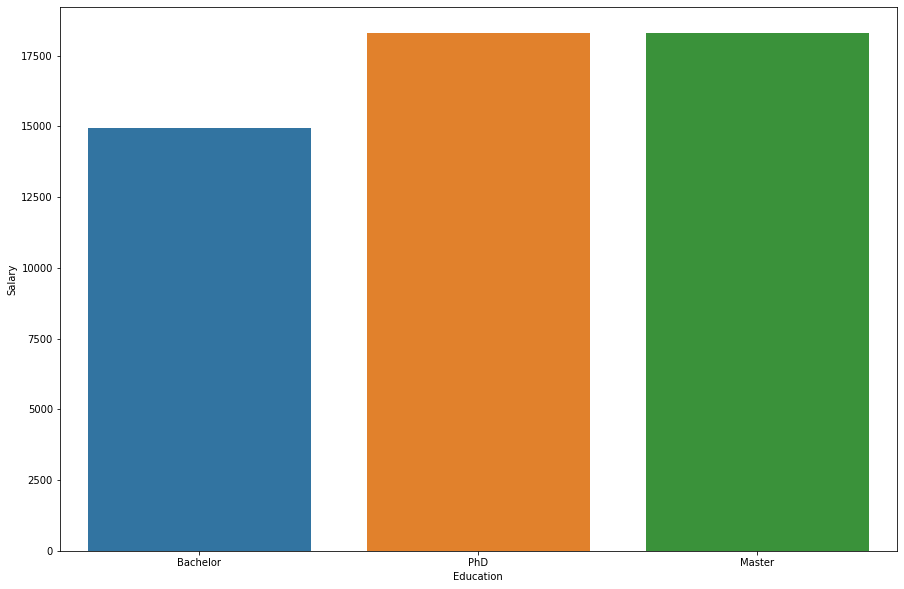

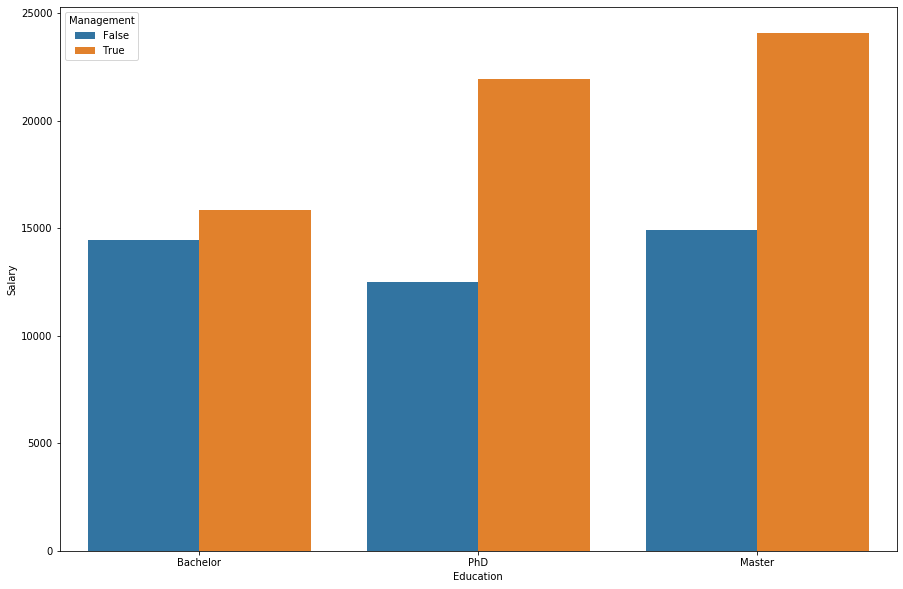

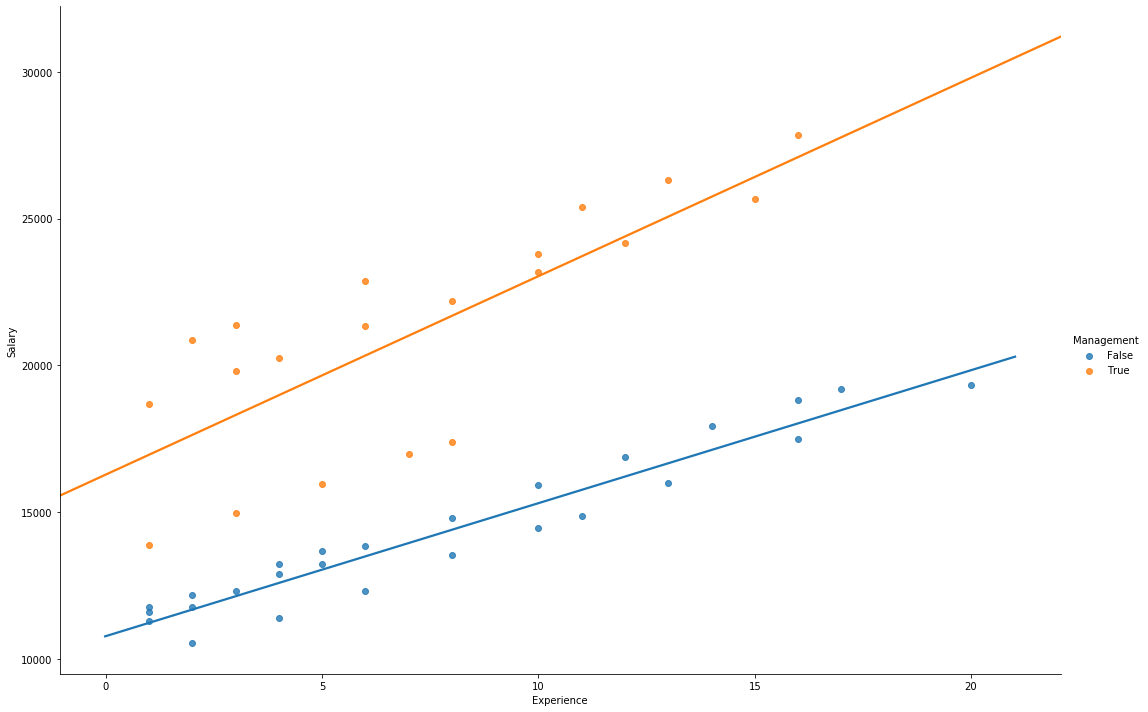

In [13]:
plt.figure(figsize=(15,10))
sns.barplot(x='Education', y='Salary', data=data, ci=None)
plt.figure(figsize=(15,10))
sns.barplot(x='Education', y='Salary', hue='Management', data=data, ci=None)
sns.lmplot(x='Experience', y='Salary', hue='Management', data=data, ci=None, size=10, aspect=1.5)

<hr>
We clearly see that there is a correlation in <i>Salary</i> and whether a person has undergraduate or graduate study levels. However the correlation does not hold when we separate the cases with respect to the <i>Management</i> variable as clearly the PhD salaries decrease. On the other hand, the correlation clearly holds with respect to <i>Experience</i>, independently of the <i>Management</i> variable.
<br><br>
To see it more clearly, we plot a correlation matrix after categorically splitting the <i>Education</i> variable. For this, we use the <code>pd.get_dummies()</code> function, where the categories are transform as binary columns in which a value of 1 corresponds to the existence of the category in the sample. We also drop one of the columns as only $k-1$ variables (where $k$ is the number of categories) are linearly independent.
<hr>

                    Salary  Experience  Management  Education_Master  \
Salary            1.000000    0.538886    0.729525          0.182727   
Experience        0.538886    1.000000   -0.051441          0.142423   
Management        0.729525   -0.051441    1.000000         -0.112297   
Education_Master  0.182727    0.142423   -0.112297          1.000000   
Education_PhD     0.137589   -0.240695    0.228662         -0.526514   

                  Education_PhD  
Salary                 0.137589  
Experience            -0.240695  
Management             0.228662  
Education_Master      -0.526514  
Education_PhD          1.000000  


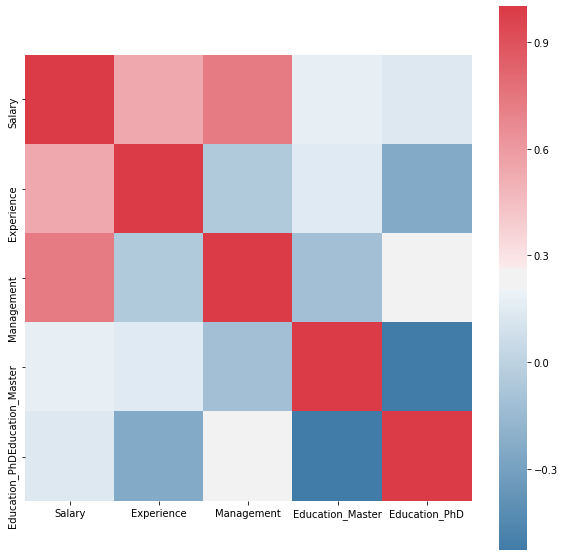

In [33]:
data = pd.get_dummies(data, drop_first=True)  # Transform categorical data ('Education')

# Correlation matrix
corr = pd.DataFrame(data).corr()
print(corr)

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(240, 10, as_cmap=True), square=True, ax=ax)

<hr>
We again notice that the <i>Salary</i> is more influenced by the <i>Experience</i> and <i>Management</i> variables than the <i>Education</i> one. However, a Master's appears to have more effect than PhD -- as we found before.
<br><br>
On the other hand, the <i>Management</i> variable is by far more affected by the <i>Salary</i>, followed by a PhD education level.

## Predictive models

We now construct predictive models for the <i>Salary</i> variable and, then, for the <i>Management</i> categorical variable. 

### Linear Regression

We construct a simple linear regressor using <code>LinearRegression()</code> from <code>sklearn.linear_model</code>. As test metrics, we will apply the <b>root mean squared error</b> and the <b>coefficient of determination</b> $R^2$ (score).

In [15]:
seed = 123
X = data.drop(['Salary'], axis=1)  # Features
y = data['Salary']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_error = mse(y_test, y_pred)**(1/2)
lr_accuracy = r2_score(y_test, y_pred)

print('Test set RMSE of linear regressor: {:.2f}'.format(lr_error))
print('Test set score of linear regressor: {:.4f}'.format(lr_accuracy))

Test set RMSE of linear regressor: 1127.19
Test set score of linear regressor: 0.9434


<hr>
The simple Linear Regressor performs fairly well, with a score of 94.34% when applied on the test set.
<br><br>
One important tool to understand how each of the variables affects the performance of the model is the <b>partial-dependence plots</b>. In these plots, if there are more variation for any given predictor variable that means the value of that variable affects the model quite a lot but if the line is constant near zero it shows that variable has no affect on the model. On the y-axis, having a negative value means for that particular value of predictor variable it is less likely to predict the correct class on that observation and having a positive value means it has positive impact on predicting the correct class. 
<hr>


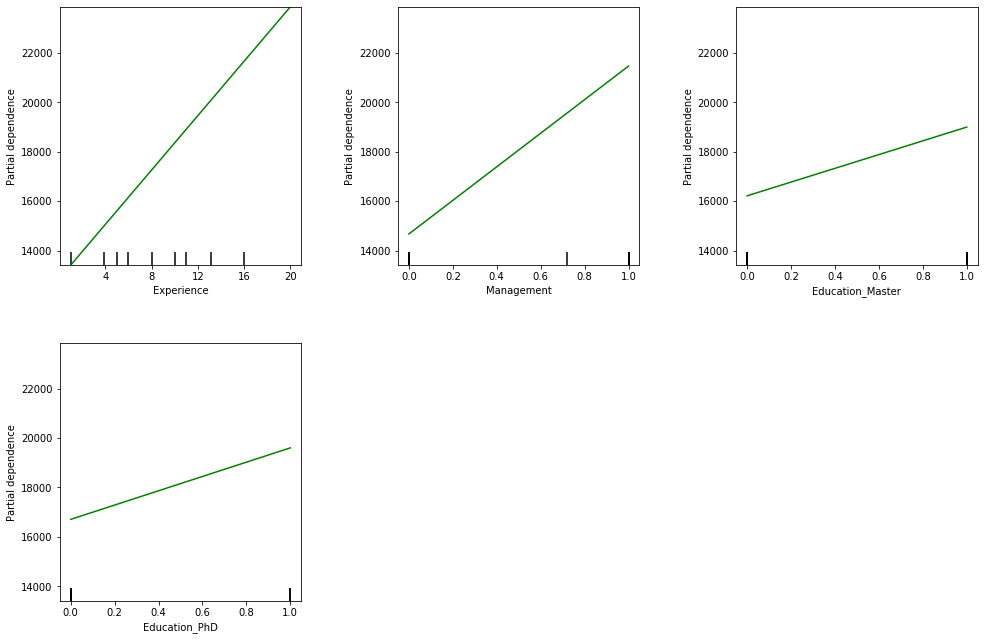

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_partial_dependence(lr, features=[0, 1, 2, 3], X=X_train, feature_names=X.columns, fig=fig)

<hr>
We clearly see that there exist linear relationships between <i>Salary</i> and the rest of variables but <i>Experience</i> and <i>Management</i> influence more greatly than the others.

### Logistic Regression

We now want to see how the <i>Salary</i>, <i>Education</i> and <i>Experience</i> affect whether a person has a <i>Management</i> position or not.
<br><br>
This is a classification problem. Therefore, we construct a logistic regression model and, accordingly, our test metrics will include the <b>confussion matrix</b> and the Receiver Operating Characteristic (<b>ROC</b>) curve (a plot of the true positive rate against the false positive rate) for which we compute the <b>area under the curve</b>, metric which tells us how good our model is in general.
<hr>

Confusion matrix:
[[4 3]
 [1 6]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.67      0.86      0.75         7

    accuracy                           0.71        14
   macro avg       0.73      0.71      0.71        14
weighted avg       0.73      0.71      0.71        14


Model score (area under the ROC curve):
0.9183673469387754


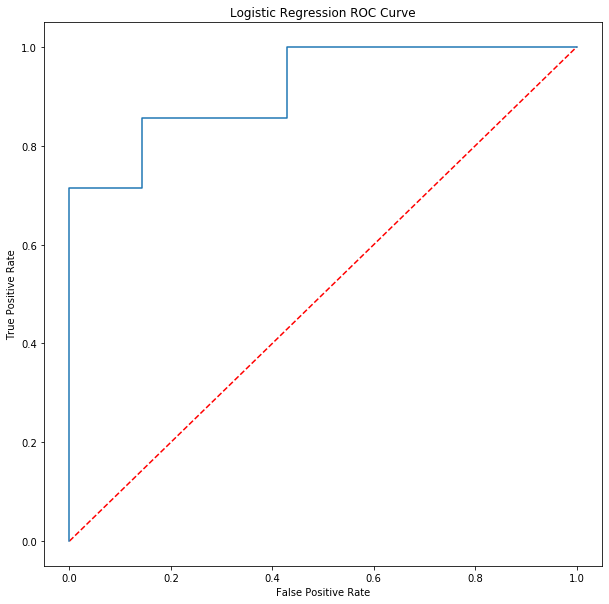

In [41]:
# Transform Boolean to categorical
data['Management'] = data['Management'].astype('category')
data['Management'] = data['Management'].cat.codes

X = data.drop(['Management'], axis=1)  # Features
y = data['Management']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

logreg_error = mse(y_test, y_pred)**(1/2)
logreg_accuracy = r2_score(y_test, y_pred)

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Plot ROC curve
plt.figure(figsize=(10, 10))
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')

print('\nModel score (area under the ROC curve):')
print(roc_auc_score(y_test, y_pred_prob))

<hr>
We can see that for the small test set, the logistic regressor has an averaged precision of 85% (correct predictions), a f-1 score of 79% (correct positive predictions) and, in general, a model score of 91.8% (area under the ROC curve).
<br><br>
As for the feature importances, we show the partial-dependence plots for our logistic regressor model.
<hr>

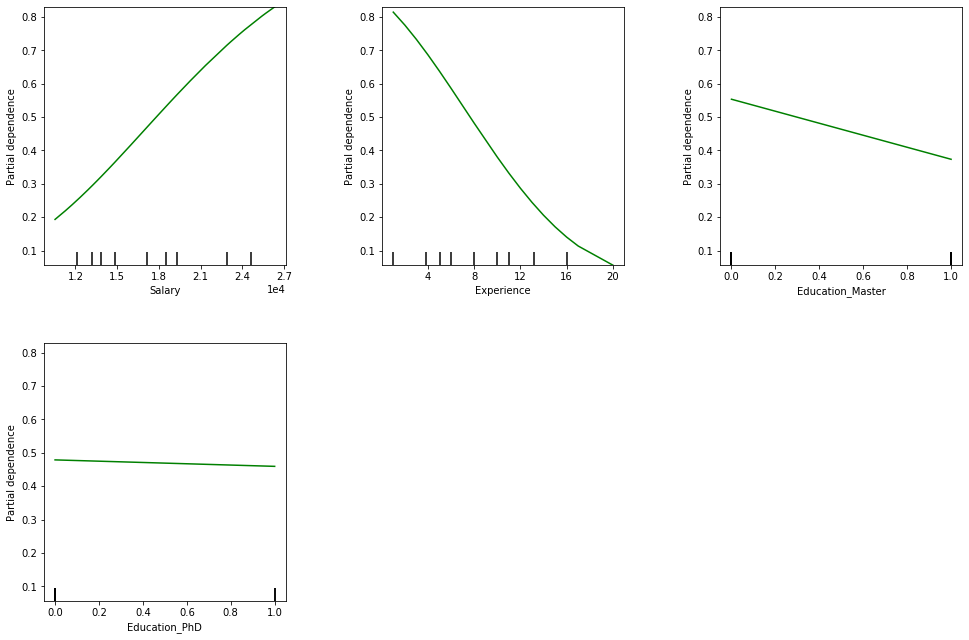

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_partial_dependence(logreg, features=[0, 1, 2, 3], X=X_train, feature_names=X.columns, 
                        fig=fig)

<hr>
As previously, we se the linear relationship of <i>Salary</i> and <i>Management</i> whereas we now notice the inverse relationship of <i>Managemente</i> and <i>Experience</i>: as <i>Experience</i> increases it is more probable to predict a non management position. On the other hand, the <i>Education</i> variables do not affect greatly the target variable and thus we could drop them from the analysis--this would not affect the model score. 
<hr>